In [9]:
HTML_MODE = True
if not HTML_MODE:
    %matplotlib widget
else:
    %matplotlib inline

### 週販レポート2025年版
# 標準ライブラリ
import os
from datetime import datetime, timedelta

# サードパーティライブラリ
import pandas as pd
from pandas import Timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import Markdown, display

# プロジェクト内モジュール
from gamedata import hard_sales as hs
from gamedata import plot_hard as ph
from gamedata import hard_info as hi
from gamedata import hard_event as he
from gamedata import chart_hard as ch

# レポート日付
from report_config import get_config

config = get_config()
report_date = config["date"]
report_event_mask = {'hard': 2.0, 'price':5, 'sale':5, 'soft':1.0}

def show_title(d:datetime) -> None:
    last_updated_str = d.strftime("%Y-%m-%d")
    mode = "[[LAB MODE]]" if not HTML_MODE else ""
    display(Markdown(f"# 国内ゲームハード週販レポート ({last_updated_str}) {mode}"))

show_title(report_date)

if not HTML_MODE:
    plt.show()

# 国内ゲームハード週販レポート (2025-09-14) 

* ハードウェアの販売データはファミ通の調査結果を元にしています。
* 一部のデータについては処理の都合上、1週間毎の値にアレンジしています。
* [過去の週販レポート](index.html)

## 直近4週間のハード売り上げ／累計推移


Switch2が累計200万台を突破しました。
出荷状況は5万台弱で、8月後半からの出荷が絞られた状況が続いています。
Nintendo Directに合わせた出荷増はありませんでした。
10月2日のマリオギャラクシーに合わせて出荷が増える事を期待したいですね。

PS5はオータムセールの効果で今週もSwitchを超えていますが、
来週から年末に予想される次のセールまでは4桁に落ち込むと思われます。
もしかしたら10月2日のGhost of Yoteiで少し上がるかもしれません。

In [2]:
def chart_4weeks() -> None:
    df1 = hs.load_hard_sales()
    # 4 weeks before
    before_4weeks = hs.current_report_date(df1) - Timedelta(weeks=4-1)
    (out1, style1) = ch.chart_units_by_date_hw(df1, begin=before_4weeks)
    display(style1)
    
chart_4weeks()

## 2025年の週販推移

現在はどの機種も5万以下の推移が続いています。年末モードに入る10月から10万近辺の値が出てくるのに期待です。

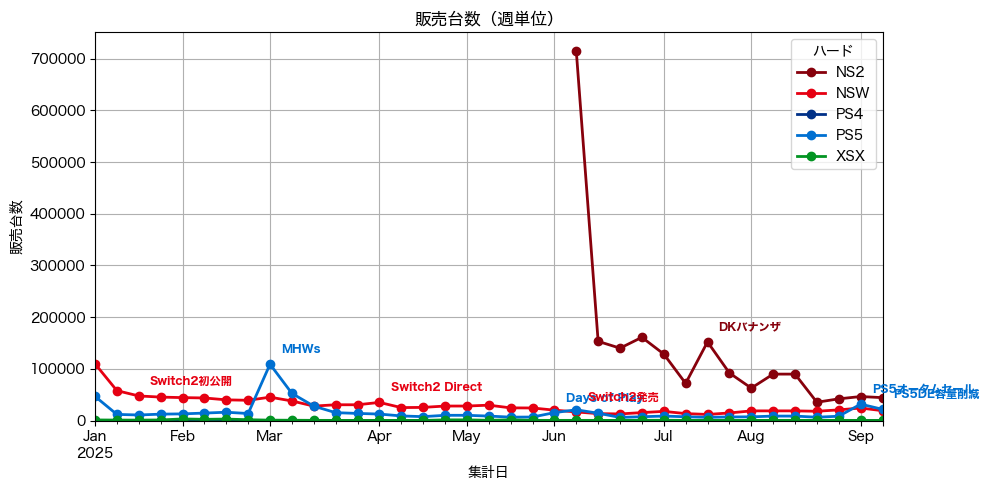

In [10]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), event_mask = report_event_mask)

### 2025年の週販推移(拡大）

先週に引き続きPS5 オータムセールの効果が出ています。


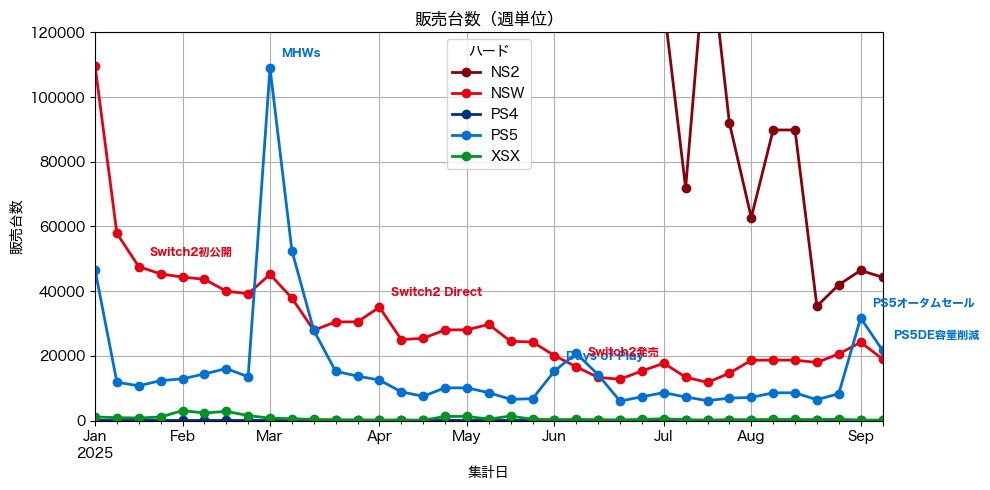

In [11]:
(fig, df) = ph.plot_sales(begin=datetime(2025,1,1), ymax=120000, event_mask=report_event_mask)

## Switch2 200万台到達

Switch2の200万台到達は14週目、
GAMEBOY ADVANCEの12週目に続く歴代2位、
据え置き機ならPlayStation2を超えて歴代1位です。

生産量抑え気味だったSwitchが34週目なのに比べると倍以上の普及速度です。

In [12]:
hard_sales_df= hs.load_hard_sales()
df = hs.extract_week_reached_units(hard_sales_df, threshold_units=2000000)
df = df[['full_name', 'report_date', 'delta_week','sum_units']]
df = df.sort_values(by=['delta_week'])
df.columns = ['ハード', '達成年週', '週数', '累計販売数']
df.set_index(['ハード'], inplace=True)
display(df.head(10))

,達成年週,週数,累計販売数
ハード,,,
GAME BOY ADVANCE,2001-06-17,12,2043244
Nintendo Switch2,2025-09-14,14,2024761
PlayStation2,2000-06-25,16,2008755
Wii,2007-04-08,18,2038951
Nintendo DS,2005-05-01,21,2037178
Nintendo 3DS,2011-10-09,32,2024869
Nintendo Switch,2017-10-29,34,2041221
PocketStation,1999-10-10,37,2051852
PlayStation Portable,2005-11-06,47,2003979


### Switch2は年内にどこまで売れるか（過去の事例から）

過去の年末商戦の状況から、日本のゲーム年末商戦の上限値を見てみます。
以下は過去の10月〜12月のハード販売台数のトップ10です。


In [68]:
df = hs.load_hard_sales()
dfQ3 = df.loc[df["month"] >= 10]
dfQ3_sum = hs.yearly_sales(dfQ3)
dfQ3_sum = dfQ3_sum.sort_values(by=['yearly_units'], ascending=False)
dfQ3_sum.rename(columns={"yearly_units": "10月〜12月", "hw": "ハード", "year": "年"}, inplace=True)
dfQ3_sum.drop(columns=["sum_units"], inplace=True)
dfQ3_sum.reset_index(inplace=True, drop=True)
dfQ3_sum_top10 = dfQ3_sum.head(10).style.format({'10月〜12月': '{:,.0f}'})
display(dfQ3_sum_top10)
#df = df.sort_values(by=['monthly_units'], ascending=False)
#display(df.head(20))

,年,ハード,10月〜12月
0,2006,DS,"2,880,499"
1,2012,3DS,"2,264,332"
2,2011,3DS,"2,213,938"
3,2020,NSW,"2,002,858"
4,2019,NSW,"1,975,261"
5,2005,DS,"1,915,457"
6,2013,3DS,"1,794,628"
7,2007,DS,"1,788,151"
8,2018,NSW,"1,719,871"
9,2021,NSW,"1,714,476"


DS,3DS, Switchの3機種で年末商戦TOP10を占めています。
任天堂は年末に大量のゲーム機を売ることにかけてはベテランですね。
2006年のDS 288万台が飛び抜けてますが、
これを19年後のSwitch2で再現するのは条件が違い過ぎて無理でしょう。
参考になるのは2020年,2019年のSwitch, 2012年,2011年の3DSの200万台前後の値です。

「年末商戦に200万台売れる」とは具体的にどういう状態なのか、
Switchの2020年 年末商戦の週販を見てみます。
ちなみに、2020年は春に「あつまれどうぶつの森」が発売されたコロナの年です。
この年の年末商戦では、10月には毎週10万前後、11月には15万、12月には毎週20万台を超えて30万台に達します。

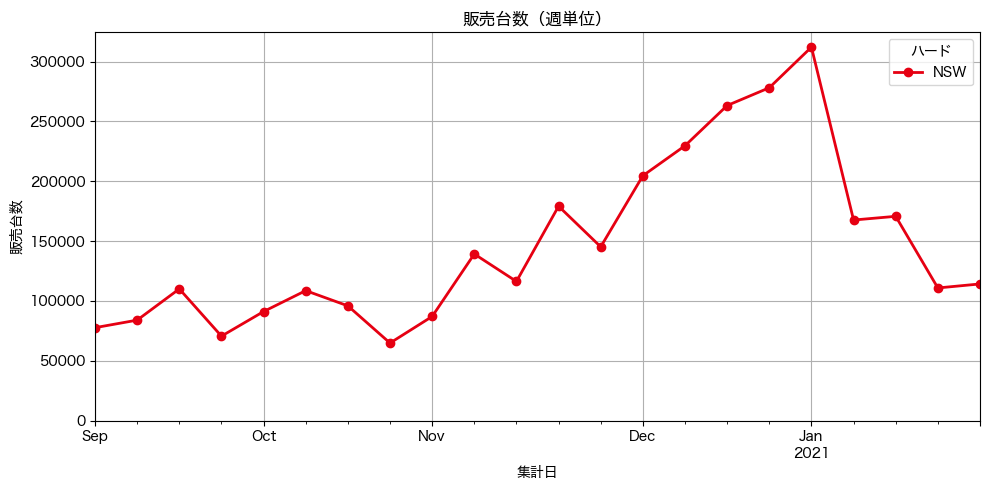

In [13]:
(fig, df) = ph.plot_sales(hw=['NSW'], begin=datetime(2020,9,1), end=datetime(2021,1,31), event_mask=report_event_mask)

#### 年末200万台は厳しそう

現在5万弱/週のSwitch2がこれを達成するには、来月には約2倍、11月には3倍、12月には4〜6倍の出荷数が必要です。
ここまで出荷されると抽選販売で捌ける量ではなく、店頭で普通に買える状態になるはずです。
ただ、マイニンテンドーストアの招待販売の条件を見るに、年内においてもSwitch2の供給には余裕が無いと見られます。
そのため、年末までにSwitch2を200万台販売するのは非常に困難な状況と推察されます。

#### もし年末200万台販売できれば...

もし年末商戦で200万台出荷できれば、Switch2は2025年内に累計400万に到達します。
そうなると、30週目での400万台到達となり、
歴代1位のGAMEBOY ADVANCEの記録を10週間縮める、24年ぶりの新記録になります。
... やはり、年末までに200万台販売するのは難しい気がしてきましたね。

In [52]:
hard_sales_df= hs.load_hard_sales()
df = hs.extract_week_reached_units(hard_sales_df, threshold_units=4000000)
df = df[['full_name', 'report_date', 'delta_week','sum_units']]
df = df.sort_values(by=['delta_week'])
df.columns = ['ハード', '達成年週', '週数', '累計販売数']
df.set_index(['ハード'], inplace=True)
display(df)

,達成年週,週数,累計販売数
ハード,,,
GAME BOY ADVANCE,2001-12-30,40,4245686
Nintendo 3DS,2011-12-25,43,4132038
Nintendo DS,2005-12-11,53,4102277
Wii,2007-12-09,53,4025012
Nintendo Switch,2018-03-25,55,4037144
PlayStation2,2001-06-03,65,4019182
PlayStation Portable,2006-09-24,93,4006979
PlayStation5,2023-07-30,141,4046566
PlayStation4,2017-01-08,150,4089279


## 2025年月間販売推移

(9月は第2週まで)

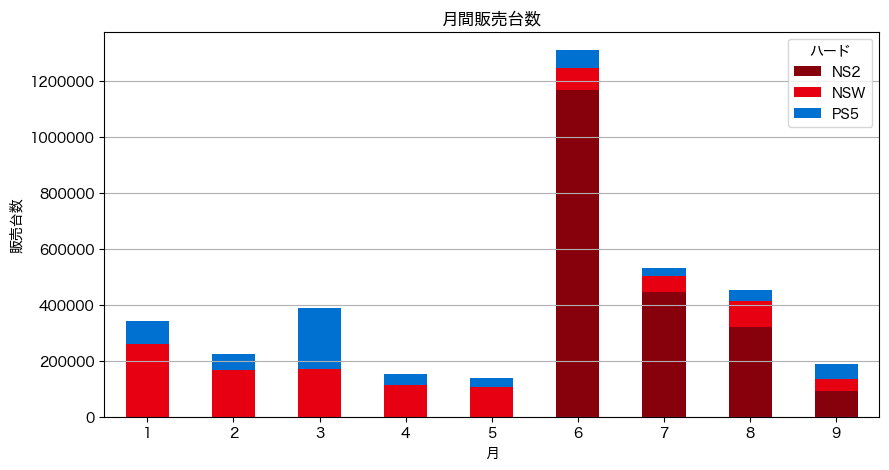

In [14]:
(fig, df) = ph.plot_monthly_bar_by_hard(hw=["NS2", "PS5", "NSW"], year=2025, stacked=True)

In [15]:
df = df.style.format({'NS2': '{:,.0f}', 'NSW': '{:,.0f}', 'PS5': '{:,.0f}'})
display(df)

hw,NS2,NSW,PS5
month,,,
1,0,"260,447","81,587"
2,0,"167,188","56,886"
3,0,"171,921","218,300"
4,0,"113,513","38,983"
5,0,"106,506","32,001"
6,"1,169,684","78,097","63,516"
7,"444,706","57,532","28,959"
8,"319,690","94,517","39,004"
9,"90,681","43,224","53,398"


### Nintendo Switchの月間販売台数： 2023,2024年との比較

9月のSwitchの前年比は大幅に低下しそうです。次世代機への切り替えと見れば順調とも言えます。

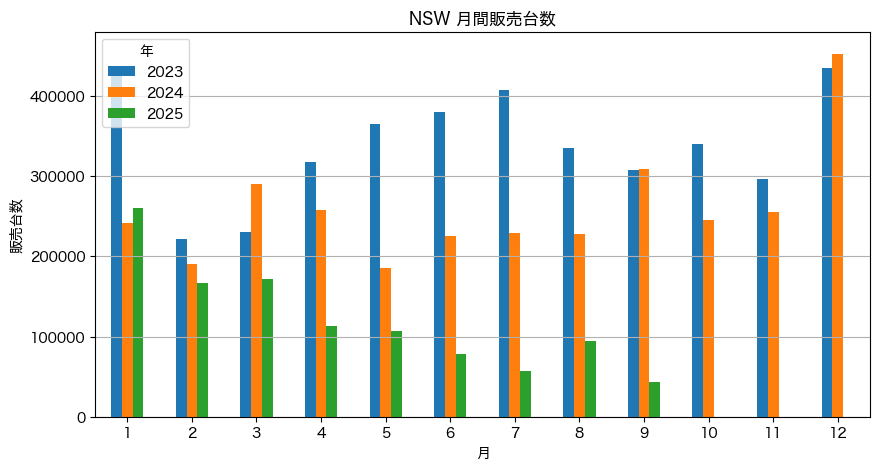

In [101]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="NSW", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,9,14))

### PlayStation 5の月間販売台数： 2023, 2024年との比較

オータムセール効果で9月は前年を上回りそうです。

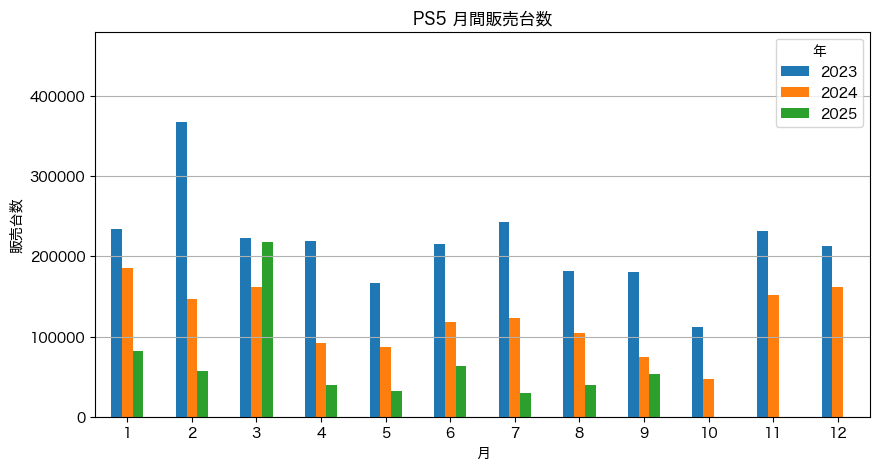

In [104]:
(fig, df) = ph.plot_monthly_bar_by_year(hw="PS5", ymax=480000, begin=datetime(2023,1,1), end=datetime(2025,9,14))

## 累計販売推移

累計については、しばらく状況変化無いでしょう。ホリデーシーズンに各機どこまで上昇カーブが描けるか。

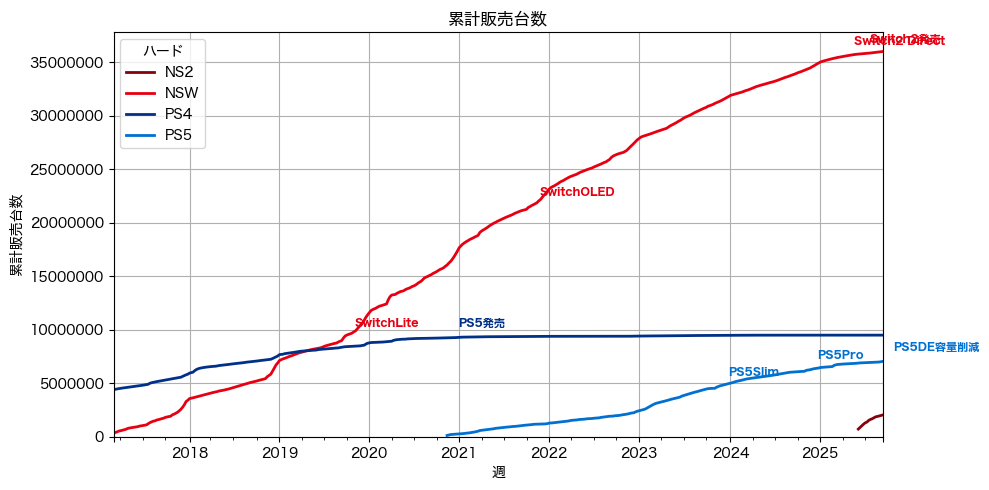

In [25]:
long_range_event_mask = {'hard': 1}
(fig, df) = ph.plot_cumulative_sales(hw=['PS4', 'NS2', 'PS5', 'NSW'], begin=datetime(2017,3,1), event_mask = long_range_event_mask)


## Switch2販売状況

### 歴代機種との比較

Switch2はGBAに次ぐ歴代2位の初動を維持していますが、出荷制限の影響が続いています。

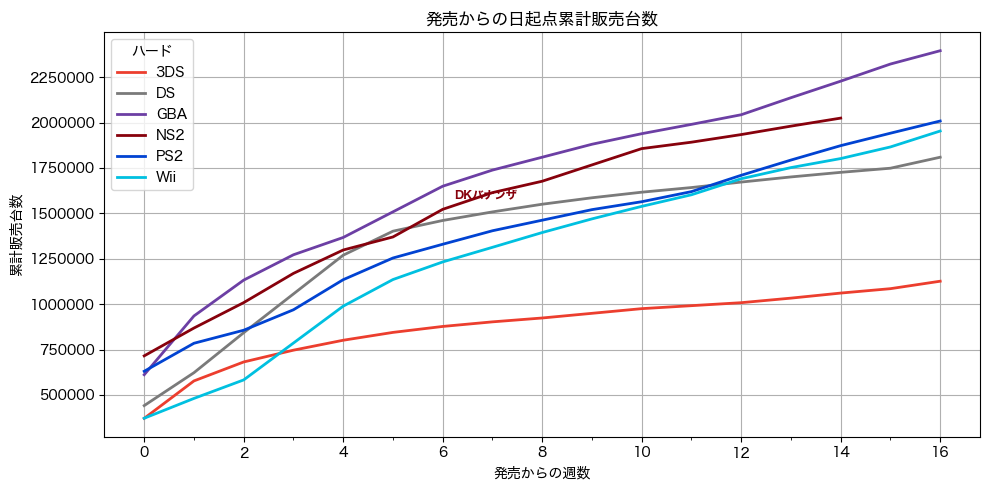

In [28]:
(fig, df) = ph.plot_cumulative_sales_by_delta(hw=["GBA", "NS2", "DS", "PS2", "Wii", "3DS"], 
                                        mode="week", xgrid=2, end=16,
                                        event_mask=report_event_mask)

In [107]:
df12 = df.iloc[df.index == 14]
# df12をunpivotして、列名を"ハード"、"販売数"にする
df12_unpivot = df12.unstack().reset_index()
df12_unpivot.columns = ['ハード', '週数', '販売数']
df12_unpivot.sort_values(by='販売数', ascending=False, inplace=True)
df12_unpivot.set_index('ハード', inplace=True)
display(df12_unpivot.style.format({'販売数': '{:,.0f}'}))

,週数,販売数
ハード,,
GBA,14,"2,228,159"
NS2,14,"2,024,761"
PS2,14,"1,873,108"
Wii,14,"1,801,988"
DS,14,"1,726,027"
3DS,14,"1,061,201"


## Switch/Switch2ロンチ比較

ロンチ週以降のSwitchとSwitch2の販売状況の比較です。
大量出荷される段階は終わり、Switchよりはマシ程度の水準で推移しています。
17週目から10月に入りますが、そこで、どこまで増えるかに注目です。

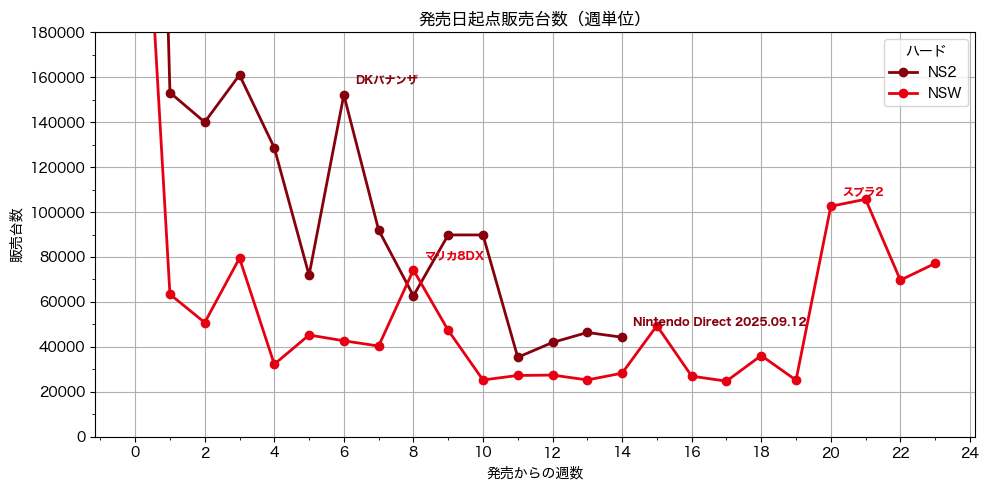

In [31]:
switch_event_mask ={'hard': 5, 'event': 2, 'soft':3, }
(fig, df) = ph.plot_sales_by_delta(hw=["NSW", "NS2"], end=23, ymax=180000, xgrid=2, ygrid=20000, mode="week", event_mask=switch_event_mask)


## 年単位の状況

(2025年については9月までの状況です)

全機種合わせた年毎のハード販売の状況です。
2024年は500万台を割り込む状況でしたが、2025年は500万台を超える可能性があります。
というかSwitch2ローンチ年に超えないとヤバイですね。全てはSwitch2の出荷次第です。
順調なら年間600万の水準も狙えます。

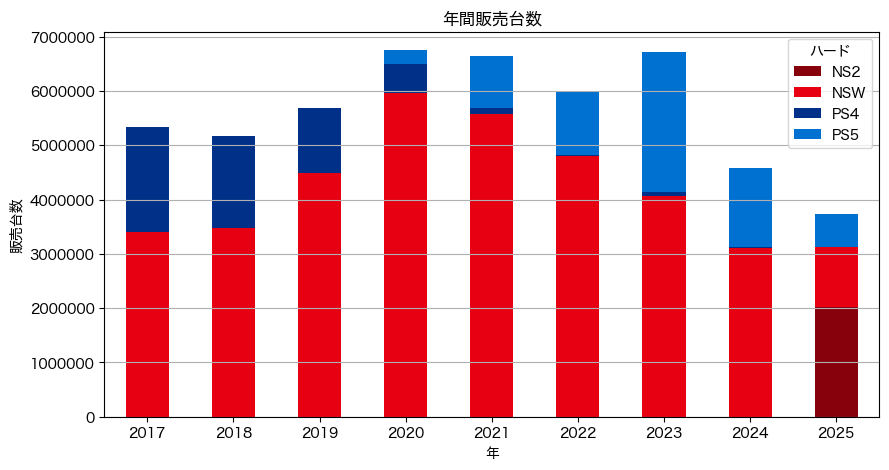

In [32]:
(fig, df) = ph.plot_yearly_bar_by_hard(hw=['PS4', 'PS5', 'NSW', 'NS2'], begin=datetime(2017,1,1), end=datetime(2025,12,31), stacked=True)

Switch2の販売台数の延びにより、任天堂が2025年に記録的シェアを達成する可能性が高まっています。

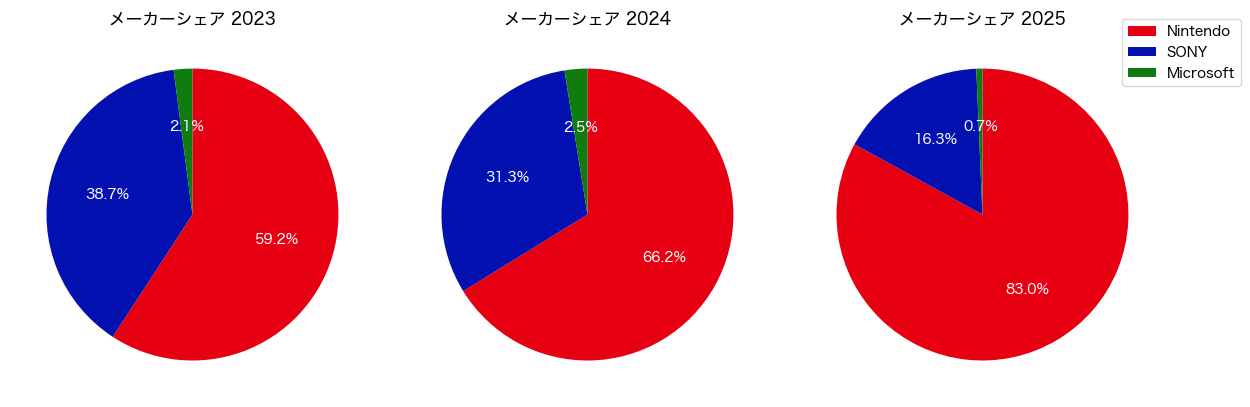

In [110]:
(fig, df) = ph.plot_maker_share_pie(begin_year=2023, end_year=2025)